In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# from test import Judge

class NomalBlock(nn.Module):
    
    '''
    实现子module: Residual Block
    '''
    
    def __init__(self,inchannel,outchannel,stride=1):
        
        super(NomalBlock,self).__init__()
        
        
#         self.nomal = nn.ModuleList([nn.Sequential(nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
#                                                   nn.BatchNorm2d(outchannel),
#                                                   nn.ReLU(inplace=True)),
#                                     nn.Sequential(nn.Conv2d(outchannel,outchannel,3,1,1,bias=False),
#                                                   nn.BatchNorm2d(outchannel))])
        self.nomal = nn.Sequential(nn.Conv2d(inchannel,outchannel,3,stride,1,bias=False),
                                                  nn.BatchNorm2d(outchannel),
#                                                   nn.ReLU(inplace=True)
                                                  nn.Mish()
                                  )
   
    
    def forward(self,x):
        
#         out = x
#         for model in self.nomal:
        x = self.nomal(x)
        return x

class PreInputBlock(nn.Module):
    
    '''
    实现子module: Residual Block
    '''
    
    def __init__(self,outchannel,stride=1):
        
        super(PreInputBlock,self).__init__()
        
        self.pre = nn.ModuleList([nn.Sequential(nn.Conv2d(3, outchannel,1,stride, bias=False),
                                                nn.BatchNorm2d(outchannel))])
        
    
    def forward(self,x):
        out = x
        for model in self.pre:
            out = model(out)
        return out
    
class skipnet18(nn.Module):
    
    '''
    实现主module：SkipNet34
    SkipNet34 包含多个正常layer和多个数据输入预处理layer，
    用子module来实现nomal block 和pre-input block，用_make_pre_layer和_make_layer函数来实现layer
    '''
    def __init__(self,num_classes=10):
        
        super(skipnet18,self).__init__()
        self.k = 1        
        # 前几层图像转换
        self.first=nn.Sequential(
            nn.Conv2d(3,64,3,stride=1,padding=1,bias=False),
            nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
            nn.Mish(),
            # nn.MaxPool2d(3,1,1)
        )
        self.layer1 = nn.Sequential(
           nn.Conv2d(3, 3, kernel_size=1, stride=1, bias=False),nn.BatchNorm2d(3)
        )
        # 分别有6，8，12，6个数据预输入层
        self.total_pre_layers = nn.ModuleList()
        #self.total_pre_layers.extend(self._make_pre_layer(outchannel=64,bloch_num=5,stride=1))
        self.total_pre_layers.extend(self._make_pre_layer(outchannel=64,bloch_num=5,stride=1))
        self.total_pre_layers.extend(self._make_pre_layer(outchannel=128,bloch_num=4,stride=2))
        self.total_pre_layers.extend(self._make_pre_layer(outchannel=256,bloch_num=4,stride=4))
        self.total_pre_layers.extend(self._make_pre_layer(outchannel=512,bloch_num=4,stride=8))  
        
        #64*16*16
        # 重复的layer，分别有3，4，6，3个nomal block
        self.total_layers = nn.ModuleList()
        self.total_layers.extend(self._make_layer(64,64,4))
        self.total_layers.extend(self._make_layer(64,128,4,stride=2))
        self.total_layers.extend(self._make_layer(128,256,4,stride=2))
        self.total_layers.extend(self._make_layer(256,512,4,stride=2))

        self.fc=nn.Linear(512,num_classes)
    def _make_pre_layer(self,outchannel,bloch_num,stride=1):
        '''
        构建数据输入层
        '''
        layers = nn.ModuleList()
        for i in range(bloch_num):
            layers.append(PreInputBlock(outchannel,stride))
        return layers
        
    
    def _make_layer(self, inchannel, outchannel, bloch_num, stride=1):
        
        '''
        构建layer,包含多个nomal block
        '''
        layers = nn.ModuleList()
        layers.append(NomalBlock(inchannel, outchannel, stride))
        for i in range(1, bloch_num):
            layers.append(NomalBlock(outchannel, outchannel, 1))
        

        return layers
    
    def forward(self,x):  
#         print(“网络”,self.k)

        if self.k == 1:
#             x = self.layer1(x)
            x = self.first(x)
            for model in self.total_layers:
                    x = model(x)
                    
        else:
            x = self.total_pre_layers[self.k-2](x)
            if self.k < 18:
                # 即对一个可遍历的数据对象(如列表、元组或字符串)，enumerate会将该数据对象组合为一个索引序列，同时列出数据和数据下标。
                for i, layers in enumerate(self.total_layers):
                    if i >= self.k-2:
                            x = layers(x)

        x=F.avg_pool2d(x,4)
        x=x.view(x.size(0),-1)
        return self.fc(x)    

    
    def GetK(self,k):
        # k代表输入路径
        self.k = k
    

#if __name__ == '__main__':

    #print(Skipnet18())
    
#     print()
    #model = skipnet18()
    #print(model.total_pre_layers)
    #print(model.total_layers)
   # print(model)
#     print(model.total_layers[1])
    #model = model.to('cuda')
    #summary(model, input_size=(3, 32, 32), batch_size=-1, device='cuda')

    #print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")
    


In [ ]:
# 使用cifar10数据集，跳跃网络

from numpy import log2
import torch
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d
import torchvision
from torch.utils.data import DataLoader, dataloader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm


# 图像预处理
transform_train = transforms.Compose([  
    transforms.ToTensor(),  
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=True,transform=transform_train,download=True)
test_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=False,transform=transform_test,download=True)


# 添加tensorboard画图可视化
writer = SummaryWriter("../skipnet18/logs_train")

#数据集长度
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)
print("cifar10训练集长度：{}".format(train_data_size))
print("cifar10测试集长度：{}".format(test_data_size))

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


model = skipnet18().to(device)


#创建损失函数（交叉熵损失函数）
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
#创建优化器
LR = 0.001#或者使用1e-2代替0.01
optimizer = torch.optim.SGD(model.parameters(),lr=LR, momentum=0.9, weight_decay=5e-4)

# 获取网络参数
def GetParametaer(net):
    # Get parameters of the net
    list = []
    for __, parameter in net.named_parameters():
        list.append(parameter)
    
    return list
  
def GetNum(NumOfLayers,x):

    model.GetK(NumOfLayers)
    x = model(x)
    return x
#bitch_size    
# 从不同路径进入后可以得到每一层的输出
def Get_layers_OutNums(x):
    list_3 = []
    for i in range(1,19):
        temp = x
        temp = GetNum(i,temp)
        temp = F.softmax(temp,dim=1)
        list_3.append(temp)
    return list_3



# 获得损失值最小的那条路径
def LossOfEveryLayers(x, y,LossFunc):
    #Get the loss ofc every linaer layer
    loss_of_layer = []
    for i in range(18):
        # LossFunc：交叉熵，x是图片的预测输出，y是标签值
        loss_of_layer.append(LossFunc(x[i],y))


    return loss_of_layer.index(min(loss_of_layer))+1

    


def OutPut(layers_out):
    layers_out_ = torch.stack(layers_out,0).to(device)

    temp2 = torch.max(layers_out_,2)[0].argmax(0)

    temp3 = torch.arange(0,len(temp2))
    
    output_  = layers_out_[temp2,temp3].to(device)
    
    return output_

def returnk(layers_out):
   
    layers_out_ = torch.stack(layers_out,0).to(device)
    temp = torch.max(layers_out_,2)[0].argmax(0)
    temp2 = temp.tolist()
    k = max(temp2,key=temp2.count)+1
    return k


plt.figure()

#训练的次数
total_train_step = 0
#测试次数
total_test_step = 0
total_train_accuracy = 0
# Decey_x = 0.5
total_train_accuracy_list = []
total_test_accuracy_list = []
change_k = 0
best_acc = 0


for i in range(30):
    
    print("第{}轮训练开始".format(i+1))
    total_train_loss = 0
    total_accuracy1 = 0
    total_accuracy2 = 0
    total_accuracy3 = 0

    model.train()
    for data in tqdm(train_dataloader):

        imgs, labels = data
        imgs = imgs.to(device)      
        imgs = imgs.view(-1,3,32,32)                                  
        labels = labels.to(device)
#         layers_out = Get_layers_OutNums(imgs)
        
        if i<change_k:
            k = 1
            optimizer.zero_grad()
            model.GetK(k)
            output = model(imgs)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_step = total_train_step + 1
            accuracy1 = (output.argmax(1)==labels).sum()
            total_accuracy1 += accuracy1
            
        else:
            layers_out = Get_layers_OutNums(imgs)
            optimizer.zero_grad()
    
      
            # 1.最小损失值路径选择算法
            k_1 = LossOfEveryLayers(layers_out,labels,loss_fn)
    #         print("训练",k_1)
            # 选择损失值最小的输入路径
            model.GetK(k_1)
    #         print(test_net.k)
            outputs1 = model(imgs)
            loss1 = loss_fn(outputs1,labels)


           # 3.最优路径统计算法 
            k3 = returnk(layers_out) 
    #         print("训练",k3)
            model.GetK(k3)
            outputs3 = model(imgs)
    #         print(test_net.k)
            loss3 = loss_fn(outputs3,labels)                                                                                                                                                                                                                                      
    #         loss = loss3

             #2.个体最优路径选择算法
            outputs2 = OutPut(layers_out)
            loss2 = loss_fn(outputs2,labels)
            
            loss = loss1+loss2+loss3
    #         loss = loss2+loss3

            
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_step = total_train_step + 1
    
    #             print("训练次数:{}，loss3: {}".format(total_train_step,loss3.item()))
    #             print("训练次数:{}，loss2: {}，loss3: {}".format(total_train_step,loss2.item(),loss3.item()))
    #             print("训练次数:{}，loss1: {}，loss2: {}".format(total_train_step,loss1.item(),loss2.item()))
    
            accuracy1 = (outputs1.argmax(1)==labels).sum()
            accuracy2 = (outputs2.argmax(1)==labels).sum()
            accuracy3 = (outputs3.argmax(1)==labels).sum()
            total_accuracy1 += accuracy1
            total_accuracy2 += accuracy2
            total_accuracy3 += accuracy3
        #print("训练次数:{}，loss1: {}，loss2: {}，loss3: {}".format(total_train_step,loss1.item(),loss2.item(),loss3.item()))
    if i<change_k:
        train_accurary1 = total_accuracy1/train_data_size
        print(total_train_loss)
        print("66666在训练集上的正确率：{}".format(train_accurary1))
    else: 
        train_accurary1 = total_accuracy1/train_data_size  
        train_accurary2 = total_accuracy2/train_data_size
        train_accurary3 = total_accuracy3/train_data_size       
        print("在训练集上的loss：{}".format(total_train_loss))
        print("在训练集上的正确率：{}".format(train_accurary1))
        print("在训练集上的正确率（不用k）：{}".format(train_accurary2))
        print("在训练集上的正确率（使用计数k）：{}".format(train_accurary3))
    total_train_accuracy_list.append(train_accurary1)

    print("开始测试。。。")
    total_accuracy = 0
    #测试步骤
    #test_net.eval()
    total_test_loss = 0
    total_test_step = 0

    #model.eval()
    with torch.no_grad():
        #test_net.eval()
        for data in tqdm(test_dataloader):
            #test_net.eval()
            imgs, labels = data
            imgs = imgs.to(device)
            #imgs = imgs.view(-1,1,28,28)                              
            imgs = imgs.view(-1,3,32,32)

            labels = labels.to(device)
            if i<change_k:
                k=1
                model.GetK(k)
                output_s = model(imgs)
            else:
                layers_out2 = Get_layers_OutNums(imgs)
            
                k = returnk(layers_out2)
                model.GetK(k)
                output_s = model(imgs)

            loss = loss_fn(output_s,labels)
            total_test_loss = total_test_loss + loss.item()
            total_test_step = total_test_step + 1
            #if total_test_step%40 == 0:
            #   print("训练次数{}，loss{}".format(total_test_step,loss.item()))
            accuracy = (output_s.argmax(1)==labels).sum()
            total_accuracy += accuracy 
        test_accurary = total_accuracy/test_data_size
        print("在测试集上的正确率：{}".format(test_accurary))
        print("在测试集上的loss：{}".format(total_test_loss)) 
        # 将每次测试结果实时写入acc.txt文件中
        print('Saving model......')
        torch.save(model.state_dict(), f'../skipnet18/epoch/skipnet18_{i + 1}.pth')
        writer.add_scalar("test_loss", total_test_loss, total_test_step) 
        total_test_accuracy_list.append(test_accurary)
#     time_end=time.time()
#     print('totally cost',time_end-time_start)
        if test_accurary > best_acc:
            f3 = open("../skipnet18/best_acc.txt", "w")
            f3.write(f"训练轮次为{i + 1}时,准确率最高!准确率为{test_accurary}")
            f3.close()
            best_acc = test_accurary
print("训练结束。。。")




for i in range(len(total_test_accuracy_list)):
    with open('../skipnet18/skipnet18_acc.txt', 'a') as f:
        f.write('%d %.3f %.3f\n' % (i+1,total_train_accuracy_list[i],total_test_accuracy_list[i]))
#     with open('skip18_train_accura/te_records_k.txt', 'a') as f:
#         f.write('%d %.3f\n' % (i+1,total_train_accuracy_list[i]))
torch.save(model.state_dict(),"../skipnet18/accuracy_0.001_30_64.pkl")


        


seed is 121
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/79 [00:00<?, ?it/s]

cifar10训练集长度：50000
cifar10测试集长度：10000
cuda


100%|██████████| 79/79 [00:19<00:00,  4.12it/s]


Accuracy of airplane : 87.600 %
Accuracy of automobile : 92.200 %
Accuracy of  bird : 77.000 %
Accuracy of   cat : 68.800 %
Accuracy of  deer : 84.900 %
Accuracy of   dog : 75.200 %
Accuracy of  frog : 88.500 %
Accuracy of horse : 88.600 %
Accuracy of  ship : 91.700 %
Accuracy of truck : 90.300 %
[[876   4  27  12   6   6   9   6  34  20]
 [ 10 922   1   4   2   1   3   2  13  42]
 [ 44   2 770  45  42  34  35  17   7   4]
 [ 17   4  40 688  41 124  46  20   9  11]
 [ 11   2  36  35 849  13  22  24   5   3]
 [  9   0  36 116  31 752  18  28   7   3]
 [  9   1  26  36  22  11 885   4   3   3]
 [  8   0  16  26  35  22   4 886   1   2]
 [ 34  14   4   5   3   1   4   2 917  16]
 [ 21  40   4   4   0   3   6   6  13 903]]


<Figure size 640x480 with 0 Axes>

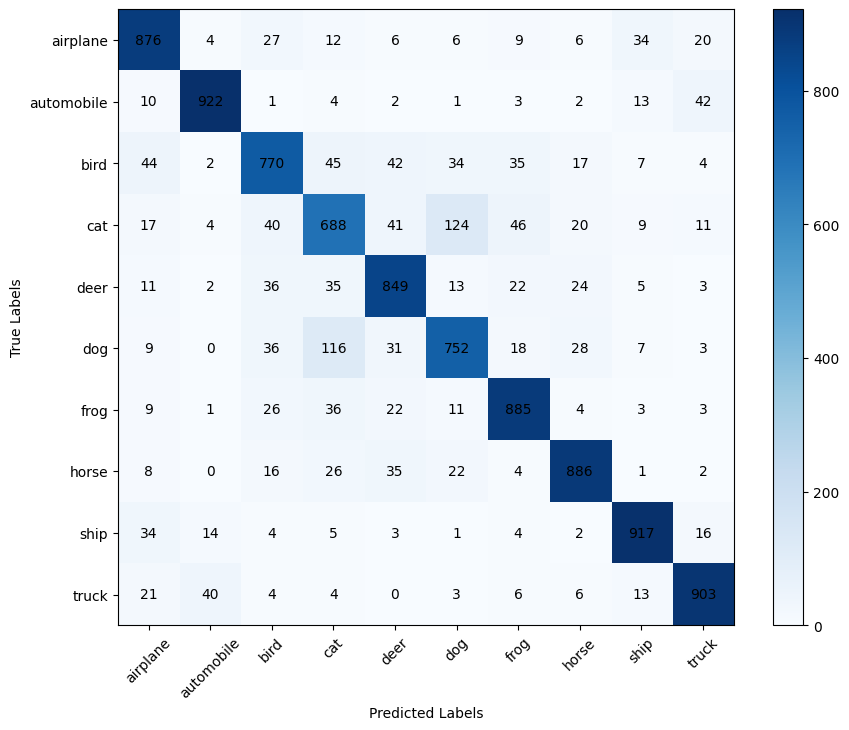

In [14]:
# 使用cifar10数据集，跳跃网络

from numpy import log2
import torch
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.pooling import MaxPool2d
import torchvision
from torch.utils.data import DataLoader, dataloader
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import time
import numpy as np
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import os
import random

seed_n = 121
print('seed is ' + str(seed_n))
g = torch.Generator()
g.manual_seed(seed_n)
random.seed(seed_n)
np.random.seed(seed_n)
torch.manual_seed(seed_n)
torch.cuda.manual_seed(seed_n)
torch.cuda.manual_seed_all(seed_n)
            # torch.backends.cudnn.deterministic=True
            # torch.backends.cudnn.benchmark = False
            # torch.backends.cudnn.enabled = False
            # torch.use_deterministic_algorithms(True)
            # os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = str(seed_n)  # 为了禁止hash随机化，使得实验可复现。

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=True,transform=transform_train,download=True)
test_dataset = torchvision.datasets.CIFAR10(root="../input/cifar10",train=False,transform=transform_test,download=True)



#数据集长度
train_data_size = len(train_dataset)
test_data_size = len(test_dataset)
print("cifar10训练集长度：{}".format(train_data_size))
print("cifar10测试集长度：{}".format(test_data_size))

train_dataloader = DataLoader(train_dataset,batch_size=128,shuffle=True,num_workers=2)
tets_dataloader = DataLoader(test_dataset,batch_size=128,shuffle=True,num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


test_net = skipnet18()

test_net.load_state_dict(torch.load("../skipnet18/accuracy_0.001_30_64.pkl"))

test_net.to(device)
#创建损失函数
loss_fn = torch.nn.CrossEntropyLoss()
loss_fn.to(device)
#创建优化器
learning_rata = 0.001
optimizer = torch.optim.SGD(test_net.parameters(),lr=learning_rata,momentum=0.9, weight_decay=5e-4)



def GetParametaer(net):
    # Get parameters of the net
    list = []
    for __, parameter in net.named_parameters():
        list.append(parameter)
    
    return list
  
def GetNum(NumOfLayers,x):

    test_net.GetK(NumOfLayers)
    x = test_net(x)
    return x
#bitch_size    
#可以得到每一层的输出
def Get_layers_OutNums(x):
    list_3 = []
    for i in range(1,19):
        temp = x
        temp = GetNum(i,temp)
        temp = F.softmax(temp,dim=1)
        list_3.append(temp)
    return list_3




def LossOfEveryLayers(x, y,LossFunc):
    #Get the loss ofc every linaer layer
    loss_of_layer = []
    for i in range(18):
        loss_of_layer.append(LossFunc(x[i],y))


    return loss_of_layer.index(min(loss_of_layer))+1

    


def OutPut(layers_out):
    layers_out_ = torch.stack(layers_out,0).to(device)

    temp2 = torch.max(layers_out_,2)[0].argmax(0)

    temp3 = torch.arange(0,len(temp2))
    
    output_  = layers_out_[temp2,temp3].to(device)
    
    return output_

def returnk(layers_out):
    layers_out_ = torch.stack(layers_out,0).to(device)
    temp = torch.max(layers_out_,2)[0].argmax(0)
    temp2 = temp.tolist()
    k = max(temp2,key=temp2.count)+1
    return k


plt.figure()

#训练的次数
total_train_step = 0
#测试次数
total_test_step = 0
total_train_accuracy = 0
# Decey_x = 0.5
total_train_accuracy_list = []
total_test_accuracy_list = []
change_k = 0


total_accuracy = 0
    #测试步骤
    # test_net.eval()
total_test_loss = 0
total_test_step = 0
# 测试模型
correct = [0] * 10
total = [0] * 10
y_pred = []
y_true = []
with torch.no_grad():
    for data in tqdm(tets_dataloader):
        images, labels = data
        images = images.to(device)
        # images = images.view(-1,3,32,32)
        labels = labels.to(device)
        layers_out2 = Get_layers_OutNums(images)
            
        k = returnk(layers_out2)
        test_net.GetK(k)
        outputs = test_net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())
        for i in range(len(labels)):
            label = labels[i]
            total[label] += 1
            if predicted[i] == label:
                correct[label] += 1

# 输出每个类别的准确率
for i in range(10):
    print('Accuracy of %5s : %.3f %%' % (
        test_dataset.classes[i], 100 * correct[i] / total[i]))


# 将预测结果转换为标签
y_pred_labels = np.array(y_pred)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_labels)

print(cm)


# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# 添加数值
for i in range(10):
    for j in range(10):
        plt.annotate(str(cm[i][j]), xy=(j, i), horizontalalignment='center', verticalalignment='center')

plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], rotation=45)
plt.yticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
# plt.show()
plt.savefig('../skipnet18/confusion_matrixA.png')
        


In [15]:
from sklearn.metrics import classification_report

# 计算准确率、召回率、精确率和 F1 值
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_true, y_pred_labels, target_names=target_names,digits=3))

              precision    recall  f1-score   support

    airplane      0.843     0.876     0.859      1000
  automobile      0.932     0.922     0.927      1000
        bird      0.802     0.770     0.786      1000
         cat      0.709     0.688     0.698      1000
        deer      0.823     0.849     0.836      1000
         dog      0.778     0.752     0.765      1000
        frog      0.858     0.885     0.871      1000
       horse      0.890     0.886     0.888      1000
        ship      0.909     0.917     0.913      1000
       truck      0.897     0.903     0.900      1000

    accuracy                          0.845     10000
   macro avg      0.844     0.845     0.844     10000
weighted avg      0.844     0.845     0.844     10000

